# 앙상블(Ensemble)

**여러 개의 머신러닝 모델을 이용해 최적의 답을 찾아내는 기법**

**앙상블 기법의 종류**
- 보팅 (Voting): 투표를 통해 결과 도출
- 배깅 (Bagging): 샘플 중복 생성을 통해 결과 도출
- 부스팅 (Boosting): 이전 오차를 보완하면서 가중치 부여
- 스태킹 (Stacking): 여러 모델을 기반으로 예측된 결과를 통해 meta 모델이 다시 한번 예측

### 분석에 필요한 패키지 Import

In [ ]:
# 다음 코드의 주석을 해제하고 패키지 설치
# !pip install xgboost lightgbm catboost scikit-learn --quiet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

SEED = 42 

In [1]:
# 데이터 분할 및 교차 검증
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# 전처리
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

# 성능 평가 지표
from sklearn.metrics import accuracy_score, classification_report

# 기본 분류 모델
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# 앙상블 모델
from sklearn.ensemble import (
    VotingClassifier,      # 보팅
    BaggingClassifier,     # 배깅
    RandomForestClassifier, # 랜덤 포레스트
    AdaBoostClassifier,    # 에이다부스트
    GradientBoostingClassifier, # 그래디언트 부스팅
    StackingClassifier     # 스태킹
)

# 부스팅 라이브러리
import xgboost as xgb           # XGBoost
import lightgbm as lgb          # LightGBM
from catboost import CatBoostClassifier  # CatBoost

맥북에서 XGBoostError 에러 뜨면 터미널에 아래 코드 입력하기!
> brew install libomp

### 데이터 로드

In [ ]:
# df라는 변수에 'Employee.csv' 파일을 읽어와 저장합니다.
df = pd.***('Employee.csv')

In [8]:
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


In [9]:
target = 'LeaveOrNot'

In [ ]:
X = *** # target 컬럼을 제외한 데이터를 X에 저장합니다.
y = df[target]

### 데이터 전처리

In [11]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 290.9+ KB


In [12]:
X.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain
0,Bachelors,2017,Bangalore,3,34,Male,No,0
1,Bachelors,2013,Pune,1,28,Female,No,3
2,Bachelors,2014,New Delhi,3,38,Female,No,2
3,Masters,2016,Bangalore,3,27,Male,No,5
4,Masters,2017,Pune,3,24,Male,Yes,2


In [ ]:
# 범주형 변수 전처리
# 일괄적으로 인코딩을 진행하겠습니다.
cat_cols = [
    'Education',
    'City',
    'Gender',
    'EverBenched'
]

for col in cat_cols:
    le = LabelEncoder()

    # 각 범주형 변수(col)에 대해 인코딩을 수행합니다.
    X[col] = le.***(X[col].astype(str)) # 힌트 : 학습하고_바로 적용하는 코드

In [14]:
# 스케일링

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

#### 훈련용 / 테스트용 데이터 분할

In [15]:
from sklearn.model_selection import train_test_split

In [ ]:
# X_scaled와 y를 훈련용과 테스트용 데이터로 분할합니다.
X_train, X_test, y_train, y_test = train_test_split(
    ***,
    ***, 
    random_state=SEED
)

In [17]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3489, 8)
(3489,)
(1164, 8)
(1164,)


## 모델링

주어진 데이터셋에 대해 단일 모델과 앙상블 기법을 적용한 모델을 각각 적용해보고 결과를 비교해봅시다.

### 단일 모델 적용

앙상블 기법을 적용하기 전에, 이전에 배웠던 단일 분류 모델들을 적용해봅시다!

(분류 기초 세션 복습 🤓)

#### 1. Logistic Regression

In [18]:
lr = LogisticRegression(random_state=SEED)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [19]:
# 예측
y_lr_pred = lr.predict(X_test)

In [20]:
lr_accuracy = accuracy_score(y_test, y_lr_pred)
lr_report = classification_report(y_test, y_lr_pred)

print(f"Accuracy score : {lr_accuracy}")
print(f"Report :\n{lr_report}")

Accuracy score : 0.7242268041237113
Report :
              precision    recall  f1-score   support

           0       0.75      0.89      0.81       775
           1       0.64      0.40      0.49       389

    accuracy                           0.72      1164
   macro avg       0.69      0.64      0.65      1164
weighted avg       0.71      0.72      0.70      1164



#### 2. 의사결정나무

In [21]:
tree = DecisionTreeClassifier(random_state=SEED)
tree.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,42
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [22]:
y_tree_pred = tree.predict(X_test)

In [23]:
tree_accuracy = accuracy_score(y_test, y_tree_pred)
tree_report = classification_report(y_test, y_tree_pred)

print(f"Accuracy score : {tree_accuracy}")
print(f"Report :\n{tree_report}")

Accuracy score : 0.8367697594501718
Report :
              precision    recall  f1-score   support

           0       0.86      0.90      0.88       775
           1       0.78      0.71      0.75       389

    accuracy                           0.84      1164
   macro avg       0.82      0.81      0.81      1164
weighted avg       0.83      0.84      0.83      1164



#### 3. SVM

In [24]:
svm = SVC(random_state=SEED)
svm.fit(X_train, y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [25]:
y_svm_pred = svm.predict(X_test)

In [26]:
svm_accuracy = accuracy_score(y_test, y_svm_pred)
svm_report = classification_report(y_test, y_svm_pred)

print(f"Accuracy score : {svm_accuracy}")
print(f"Report :\n{svm_report}")

Accuracy score : 0.8350515463917526
Report :
              precision    recall  f1-score   support

           0       0.82      0.97      0.89       775
           1       0.91      0.56      0.70       389

    accuracy                           0.84      1164
   macro avg       0.86      0.77      0.79      1164
weighted avg       0.85      0.84      0.82      1164



#### 4. kNN

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [28]:
y_knn_pred = knn.predict(X_test)

In [29]:
knn_accuracy = accuracy_score(y_test, y_knn_pred)
knn_report = classification_report(y_test, y_knn_pred)

print(f"Accuracy score : {knn_accuracy}")
print(f"Report :\n{knn_report}")

Accuracy score : 0.8410652920962199
Report :
              precision    recall  f1-score   support

           0       0.84      0.93      0.89       775
           1       0.83      0.66      0.73       389

    accuracy                           0.84      1164
   macro avg       0.84      0.80      0.81      1164
weighted avg       0.84      0.84      0.84      1164



#### 네 가지 단일 모델의 결과 비교

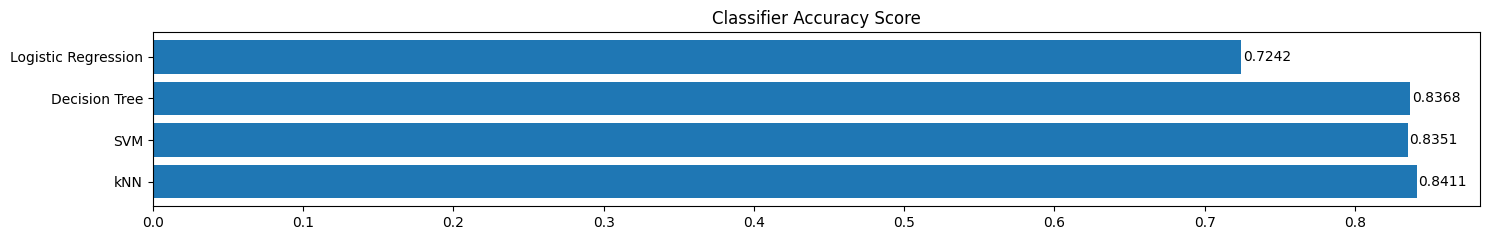

In [30]:
import matplotlib.pyplot as plt

model_name = ['Logistic Regression', 'Decision Tree', 'SVM', 'kNN']
accuracy_scores = [lr_accuracy, tree_accuracy, svm_accuracy, knn_accuracy]

plt.figure(figsize=(15, 2.5))
bars = plt.barh(model_name[::-1], accuracy_scores[::-1])

for bar, accuracy in zip(bars, accuracy_scores[::-1]):
    plt.text(bar.get_width() + 0.001, bar.get_y() + bar.get_height() / 2, f'{accuracy:.4f}', va='center')

plt.title("Classifier Accuracy Score")
plt.xlabel("")
plt.tight_layout()
plt.show()

## 앙상블 (Ensemble)

### 1. Voting

Voting은 단어 뜻 그대로 **투표를 통해 결정하는 방식**입니다. Voting은 Bagging과 투표방식이라는 점에서 유사하지만, 다음과 같은 큰 차이점이 있습니다.

- Voting은 다른 알고리즘 model을 조합해서 사용합니다.
- Bagging은 같은 알고리즘 내에서 다른 sample 조합을 사용합니다.

`VotingClassifier`

- **estimators**: 사용할 기본 분류기 리스트 (이름, 모델) 형태로 지정
- **voting**: 'hard' 또는 'soft' (기본값: 'hard')
- **weights**: 각 분류기별 가중치
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html)

In [31]:
# estimators 인자로 들어갈 분류기 리스트 지정
models = [
    ('lr', LogisticRegression(random_state=SEED)), 
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

In [ ]:
# 모델 생성
# estimators는 models로, voting은 'hard'로 설정합니다.
voting_clf = VotingClassifier(
    estimators=***, 
    voting=***
)

# 모델 훈련
voting_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_voting_pred = voting_clf.predict(X_test)

# 정확도 출력
print(f"Voting Accuracy: {accuracy_score(y_test, y_voting_pred):.4f}")

Voting Accuracy: 0.8497


### 2. Bagging

Bootstrap + Aggregating   
1. 부트스트랩을 통해 전체 데이터셋에서 중복을 허용하여 무작위로 재표본 추출을 하고,
2. 동일한 알고리즘 모델을 사용해 각각의 샘플을 독립적으로 학습하고,
3. 모든 모델의 예측값을 결합해 최종 결과를 도출하는 방법입니다.

`RandomForestClassifier`

- **n_estimators**: 트리 개수
- **max_depth**: 트리 최대 깊이
- **max_features**: 노드 분할 시 고려할 특성 수
- **min_samples_split**: 노드 분할에 필요한 최소 샘플 수
- **bootstrap**: 부트스트랩 여부 (기본값: True)

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
# 모델 생성
rf_clf = RandomForestClassifier(random_state=SEED)

# 모델 훈련
rf_clf.***(X_train, y_train) 

# 테스트 데이터에 대한 예측 수행
y_rf_pred = rf_clf.***(X_test)

# 정확도 출력
print(f"Bagging (Random Forest) Accuracy: {accuracy_score(y_test, y_rf_pred):.4f}")

Bagging (Random Forest) Accuracy: 0.8522


### 3. Boosting

약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 **가중치를 부여해 오차를 보완**해 나가는 방식입니다.

**장점** 
- 성능이 매우 우수합니다. (Lgbm, XGBoost 등)

**단점**
- 부스팅 알고리즘의 특성상 계속 약점(오분류/잔차)을 보완하려고 하기 때문에 **잘못된 레이블링이나 아웃라이어에 필요 이상으로 민감**할 수 있습니다.
- 순차적이기 때문에 병렬처리에 어려움이 있고, 그렇다보니 **학습 시간이 오래걸립니다.**.

#### 3.1 AdaBoost

- 가장 초기 모델  
- 요즘 잘 안씀

`AdaBoostClassifier`

- **estimator**: 기본 약한 학습기
- **n_estimators**: 학습기 개수
- **learning_rate**: 학습률

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [ ]:
# 모델 생성
adaboost = AdaBoostClassifier(random_state=SEED)

# 모델 훈련
adaboost.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_ada_pred = adaboost.predict(X_test)

# 정확도 출력
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_ada_pred):.4f}")

AdaBoost Accuracy: 0.8230


#### 3.2 GBM

- 성능이 우수함
- 학습시간이 해도해도 너무 느림

`GradientBoostingClassifier`

- **n_estimators**: 부스팅 단계 수
- **learning_rate**: 각 단계의 기여도
- **max_depth**: 개별 트리의 최대 깊이
- **subsample**: 학습 데이터 샘플 비율
- **min_samples_split**: 노드 분할 최소 샘플 수
- **loss**: 손실 함수 ('log_loss', 'exponential')

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

In [ ]:
# 모델 생성
gbm = GradientBoostingClassifier(random_state=SEED)

# 모델 훈련
gbm.***(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_gbm_pred = gbm.***(X_test)

# 정확도 출력
print(f"GBM Accuracy: {accuracy_score(y_test, y_gbm_pred):.4f}")

GBM Accuracy: 0.8660


#### 3.3 XGBoost

- scikit-learn 패키지 X
- GBM보다는 빠르고 성능도 향상됨
- 그러나 여전히 학습시간이 느림
- 대신 정확도가 굉장히 높아 대회에서 사용함

`XGBClassifier`

- **n_estimators**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **max_depth**: 트리 깊이
- **subsample**: 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **gamma**: 분할 최소 손실 감소
- **objective**: 목적 함수 ('multi:softprob', 'binary:logistic' 등)
- **eval_metric**: 평가 지표 ('mlogloss', 'logloss', 'error' 등)

[Docs](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier)

In [ ]:
# 모델 생성
xgboost = xgb.XGBClassifier(random_state=SEED)

# 모델 훈련
xgboost.***(***, ***)

# 테스트 데이터에 대한 예측 수행
y_xgb_pred = xgboost.***(***)

# 정확도 출력
print(f"XGBoost Accuracy: {accuracy_score(y_test, y_xgb_pred):.4f}")

XGBoost Accuracy: 0.8608


#### 3.4 LightGBM

- scikit-learn 패키지 X (Microsoft사 개발)
- 성능이 우수함
- 기존 부스팅 계열 알고리즘이 가지는 단점인 **느린 학습 속도를 개선**함

`LGBMClassifier`

- **n_estimators**: 트리 개수
- **learning_rate**: 학습률
- **max_depth**: 최대 깊이 (기본: -1 → 제한 없음)
- **num_leaves**: 리프 노드 수
- **subsample**: 데이터 샘플 비율
- **colsample_bytree**: 트리당 특성 샘플 비율
- **min_child_samples**: 리프 노드의 최소 샘플 수
- **objective**: 'binary', 'multiclass' 등

[Docs](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)

In [ ]:
# 모델 생성 (LGBMClassifier)
lgbm = lgb.***(random_state=SEED, verbose=-1)

# 모델 훈련
lgbm.***

# 테스트 데이터에 대한 예측 수행
y_lgbm_pred = lgbm.***

# 정확도 출력
print(f"LightGBM Accuracy: {accuracy_score(y_test, y_lgbm_pred):.4f}")

LightGBM Accuracy: 0.8686


#### 3.5 CatBoost

`CatBoostClassifier`

- **iterations**: 부스팅 반복 횟수
- **learning_rate**: 학습률
- **depth**: 트리 깊이
- **l2_leaf_reg**: L2 정규화 계수
- **loss_function**: 손실 함수 (예: 'Logloss', 'MultiClass')
- **random_state**: 랜덤 시드
- **verbose**: 출력 제어 (0: 진행 메시지 표시하지 않음, 100: 진행률 표시)

[Docs](https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier)

In [ ]:
# 모델 생성
cb = CatBoostClassifier(random_state=SEED, depth=10, verbose=0)

# 모델 훈련
cb.***

# 테스트 데이터에 대한 예측 수행
y_cb_pred = cb.***

# 정확도 출력
print(f"CatBoost Accuracy: {accuracy_score(***, ***):.4f}")

CatBoost Accuracy: 0.8634


### 4. Stacking

개별 모델이 예측한 데이터를 기반으로 **final_estimator** 종합하여 예측을 수행합니다.

- 성능을 극으로 끌어올릴 때 활용하기도 합니다.
- 과대적합을 유발할 수 있습니다. (특히, 데이터셋이 적은 경우)

`StackingClassifier`

- **estimators**: 기본 모델 목록 (이름, 모델) 쌍의 리스트
- **final_estimator**: 최종 분류기 (기본값: LogisticRegression)
- **cv**: 교차 검증 폴드 수 (기본값: 5)
- **passthrough**: 원본 특성을 메타 모델에 전달 여부 (기본값: False)
- **n_jobs**: 병렬 처리 수

[Docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html)

In [ ]:
base_learners = [
    ('lr', LogisticRegression(random_state=SEED)),
    ('dt', DecisionTreeClassifier(random_state=SEED)),
    ('rf', RandomForestClassifier(random_state=SEED))
]

stack_clf = StackingClassifier(
    estimators=base_learners,
    ***, # 최종 분류기를 LogisticRegression(random_state=SEED) 로 지정해주세요
    cv=5
)

# 모델 훈련
stack_clf.fit(X_train, y_train)

# 테스트 데이터에 대한 예측 수행
y_stk_pred = stack_clf.predict(X_test)

# 정확도 출력
print(f"Stacking Accuracy: {accuracy_score(y_test, y_stk_pred):.4f}")

Stacking Accuracy: 0.8531


## 앙상블 모델을 정리하며

1. 앙상블은 대체적으로 단일 모델 대비 성능이 좋습니다.
2. 앙상블을 앙상블하는 기법인 Stacking도 참고해볼만 합니다.
3. 앙상블 모델은 적절한 **Hyperparameter 튜닝**이 중요합니다.
4. 앙상블 모델은 대체적으로 학습시간이 더 오래 걸립니다.
5. 따라서, 모델 튜닝을 하는 데에 걸리는 시간도 오래 소요됩니다.

수고하셨습니다~~